#### hay que cambiar alguna cosa para usar los datos reales

In [1]:
import numpy
import scipy
from matplotlib import pyplot
from mpl_toolkits.basemap import Basemap
import matplotlib.colors
nicebwr = matplotlib.colors.LinearSegmentedColormap.from_list("nicebwr",["#094da0","#FFFFFF","#ef1a2d"])
import scha, rscha
import xyzfield, geofield, trig
import constants
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams.update({'font.family': 'Source Sans Pro'})
matplotlib.rcParams.update({'font.weight': 'normal'})

import importlib
importlib.reload(scha)

cos = numpy.cos; sin = numpy.sin

%matplotlib nbagg

In [2]:
theta_c, phi_c, theta_0d, theta_0 = numpy.deg2rad((90-42.0, 20.0, 26.0, 50.0))

In [3]:
#la data

datos_t = numpy.loadtxt("../data/rscha2d/bd_shaq.dat", skiprows=1).T

datos_t[datos_t == 999] = numpy.nan

thetav = numpy.deg2rad(90-datos_t[4])
phiv = numpy.deg2rad(datos_t[5])

in_cap = trig.angulardist(thetav, phiv, theta_c, phi_c) < theta_0d
thetav = thetav[in_cap]
phiv = phiv[in_cap]

tv = datos_t[2][in_cap]
D_o = numpy.deg2rad(datos_t[6][in_cap])
I_o = numpy.deg2rad(datos_t[7][in_cap])
F_o = datos_t[9][in_cap]

# deja de mayordomearte


In [25]:
numpy.vstack((thetav, phiv)).shape

(2, 4627)

In [4]:
#conversión a esféricas
r_geo, theta_geo, phi_geo = trig.geo2sph(thetav, phiv)

rot_mat = scha.rotation_matrix(theta_c, phi_c, invert=True)
r_geo, theta_r, phi_r = scha.rotate_coords(r_geo, theta_geo, phi_geo, rot_mat)

#en primera aproximación, a falta de algo más mejor
g01_dip = -30.0

#síntesis del dipolo en todos los datas
Bx_dip, By_dip, Bz_dip = scha.xyzfield((1,), (0,), (1,), (g01_dip,), theta_geo, phi_geo)
Bx_dip_r = numpy.empty_like(Bx_dip); By_dip_r = numpy.empty_like(By_dip); Bz_dip_r = numpy.empty_like(Bz_dip)
for i, (xx, yy, zz, th_i, phi_i, th_ri) in enumerate(zip(Bx_dip,By_dip,Bz_dip,thetav,phiv,theta_r)):
    Bx_dip_r[i], By_dip_r[i], Bz_dip_r[i] = scha.rotate_vector(xx, yy, zz, theta_c, phi_c,
                                                               th_i, phi_i, th_ri)
    
D_dip, I_dip, F_dip, H_dip = xyzfield.xyz2difh(Bx_dip, By_dip, Bz_dip)

D_res = trig.mindiff(D_o, D_dip)
I_res = trig.mindiff(I_o, I_dip)
F_res = F_o - F_dip

In [5]:
theta_0p = theta_0d + 0.1

ms = numpy.arange(0, 4);
roots = scha.degree(ms, theta0 = theta_0p, max_k = 3)
k, m, n = scha.join_roots(roots)

k, m, n = numpy.array((k, m, n))
km_even = ((k-numpy.abs(m)) % 2 == 0) & (k <= 3)
k_even, m_even, n_even = k[km_even], m[km_even], n[km_even]
m_mehler= numpy.array((0, 1, -1, 2, -2))

for ki, mi, ni in zip(k_even,m_even,n_even):
    print(f"{ki:<10} {mi:<10} {ni:<10}")

0.0        0.0        1.1645544163875254e-12
1.0        1.0        2.933925280459704
1.0        -1.0       2.933925280459704
2.0        0.0        6.4375331855248525
2.0        2.0        5.18438704387763
2.0        -2.0       5.18438704387763
3.0        1.0        9.15881506806791
3.0        -1.0       9.15881506806791
3.0        3.0        7.328856948394158
3.0        -3.0       7.328856948394158


In [6]:
import rscha_r

In [7]:
nan_D = numpy.isnan(D_o)
nan_I = numpy.isnan(I_o)
nan_F = numpy.isnan(F_o)
nan_DIF = numpy.concatenate((nan_D, nan_I, nan_F))

In [8]:
import bspline
knots = numpy.arange(-1300, 2050, 50)

At = bspline.condition_array(knots, tv)

In [9]:
Adif_rscha_test = numpy.concatenate(rscha_r.rscha_condition_matrix_dif((k_even, m_even, n_even),
                                                     (k_even[1:], m_even[1:], n_even[1:]),
                                                     m_mehler,
                                                     r_geo, theta_r, phi_r, theta_0p,
                                                     Bx_dip_r, By_dip_r, Bz_dip_r))

At3 = numpy.vstack((At, At, At))
Adift = numpy.concatenate([Adif_rscha_test*At3[:, i:i+1] for i in range(len(knots))], axis=1)[~nan_DIF, :]

In [10]:
F_dip_avg=numpy.average(F_dip)
F_res_norm = F_res/F_dip_avg

In [11]:
data = numpy.concatenate((D_res, I_res, F_res/F_dip_avg))[~nan_DIF]

In [12]:
gptlsr = numpy.linalg.lstsq(Adift, data)[0]

In [13]:
gptlsr

array([  9.42465463e-03,   1.48868523e+11,   1.46763144e+12, ...,
        -2.29168347e-01,   5.05941892e-01,   3.24339934e+00])

In [14]:
synth = Adift @ gptlsr

In [15]:
n_D, n_I, n_F = (~nan_D).sum(), (~nan_I).sum(), (~nan_F).sum()
Ds = synth[:n_D]
Is = synth[n_D:n_D+n_I]
Fs = synth[n_D+n_I:]

In [16]:
D_m = D_dip[~nan_D] + Ds
I_m = I_dip[~nan_I] + Is
F_m = Fs*F_dip_avg + F_dip[~nan_F]

In [17]:
D_res = trig.mindiff(D_m, D_o[~nan_D])
I_res = trig.mindiff(I_m,I_o[~nan_I])
F_res = F_m-F_o[~nan_F]

<IPython.core.display.Javascript object>


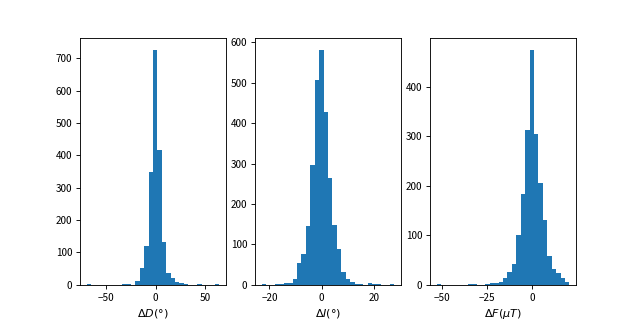

In [18]:
fig, axes = pyplot.subplots(nrows=1, ncols=3, figsize=(8, 4))

axes[0].hist(numpy.rad2deg(D_res), bins=30)
axes[0].set_xlabel("$\Delta D (°)$")
axes[1].hist(numpy.rad2deg(I_res), bins=30)
axes[1].set_xlabel("$\Delta I (°)$")
axes[2].hist(F_res, bins=30)
axes[2].set_xlabel("$\Delta F (\mu T)$")

pyplot.show(fig)
# fig.savefig("../data/rscha2d/residuos.png", frameon=True)

<IPython.core.display.Javascript object>


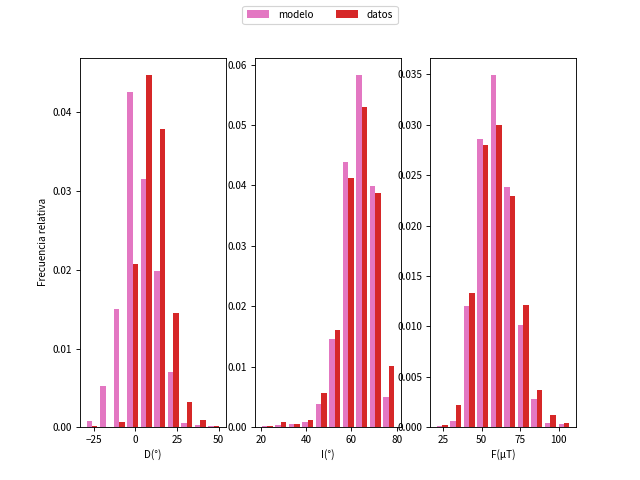

In [22]:
fig, axes = pyplot.subplots(nrows=1, ncols=3, figsize=(8, 6))

axes[0].hist((numpy.rad2deg(D_m), numpy.rad2deg(D_o)), color=("C6", "C3"), label=("modelo", "datos"), normed=True)
axes[0].set_xlabel("D(°)")
axes[1].hist((numpy.rad2deg(I_m), numpy.rad2deg(I_o)), color=("C6", "C3"), normed=True)
axes[1].set_xlabel("I(°)")
axes[2].hist((F_m, F_o), color=("C6", "C3"), normed=True)
axes[2].set_xlabel("F(μT)")
axes[0].set_ylabel("Frecuencia relativa")

fig.legend(*axes[0].get_legend_handles_labels(), 'upper center', ncol=2)

pyplot.show(fig)
fig.savefig("../data/rscha2d/distribucion.png", frameon=True)

<IPython.core.display.Javascript object>


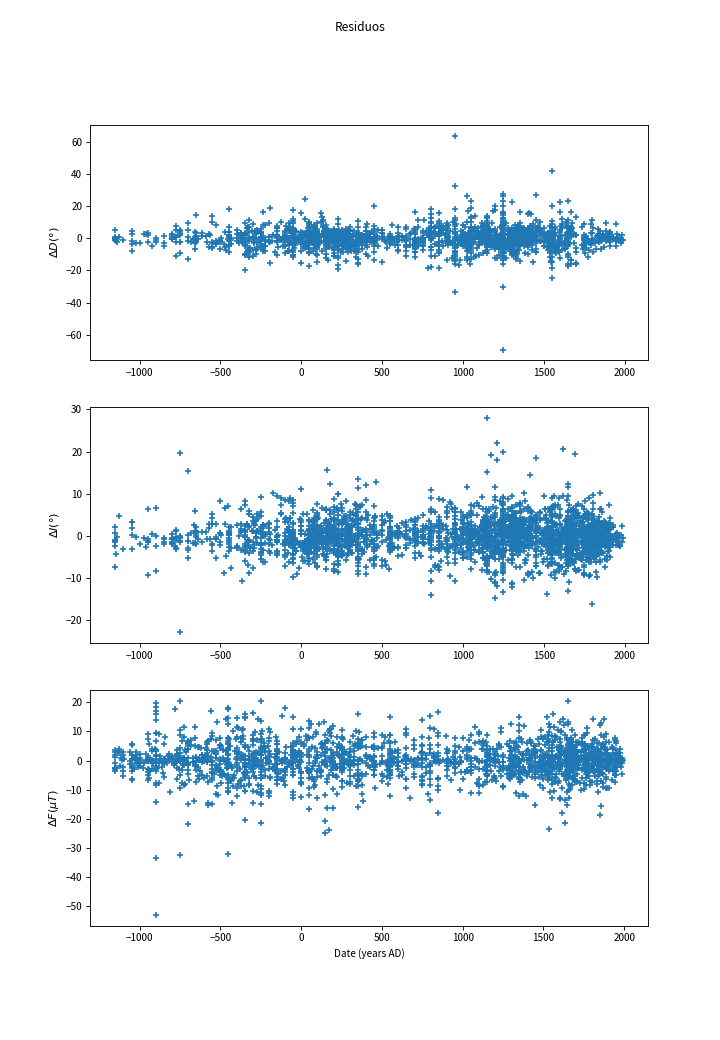

In [19]:
fig, (ax0, ax1, ax2) = pyplot.subplots(3, 1, figsize = (9,13))
ax0.scatter(tv[~nan_D], numpy.rad2deg(D_res), marker="+")
ax0.set_ylabel("$\Delta D (°)$")
ax1.scatter(tv[~nan_I], numpy.rad2deg(I_res), marker="+")
ax1.set_ylabel("$\Delta I (°)$")
ax2.scatter(tv[~nan_F], F_res, marker="+")
ax2.set_ylabel("$\Delta F (\mu T)$")
ax2.set_xlabel("Date (years AD)")

fig.suptitle("Residuos")

pyplot.show(fig)

<IPython.core.display.Javascript object>


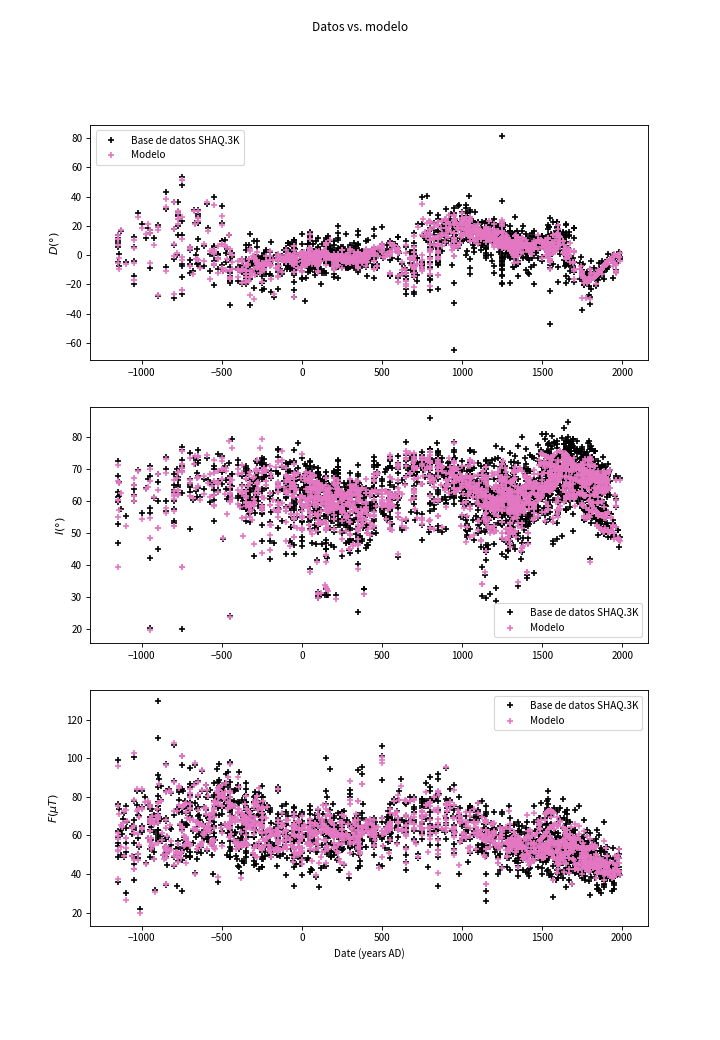

In [20]:
fig, (ax0, ax1, ax2) = pyplot.subplots(3, 1, figsize = (9,13))
ax0.scatter(tv[~nan_D], numpy.rad2deg(trig.mindiff(D_o[~nan_D], 0)),
            marker="+", color="black", label="Base de datos SHAQ.3K")
ax0.scatter(tv[~nan_D], numpy.rad2deg(trig.mindiff(D_m, 0)),
            marker="+", color="C6", label="Modelo")
ax1.scatter(tv[~nan_I], numpy.rad2deg(trig.mindiff(I_o[~nan_I], 0)),
            marker="+", color="black", label="Base de datos SHAQ.3K")
ax1.scatter(tv[~nan_I], numpy.rad2deg(trig.mindiff(I_m, 0)),
            marker="+", color="C6", label="Modelo")
ax2.scatter(tv[~nan_F], F_o[~nan_F], marker="+", color="black",
           label="Base de datos SHAQ.3K")
ax2.scatter(tv[~nan_F], F_m, marker="+", color="C6", label="Modelo")

ax0.set_ylabel("$D (°)$")
ax0.legend()
ax1.set_ylabel("$I (°)$")
ax1.legend()
ax2.set_ylabel("$F (\mu T)$")
ax2.legend()
ax2.set_xlabel("Date (years AD)")

fig.suptitle("Datos vs. modelo")
pyplot.show(fig)

In [25]:
satan = 666